In [ ]:
!pip install torch pandas scikit-learn numpy matplotlib

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
def load_separate_datasets(train_path, test_path):
    """Load and preprocess train/test data for MULTI-CLASS classification"""
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    print(f"[INFO] Train shape: {train_df.shape}, Test shape: {test_df.shape}")
    
    # Detect label column (prioritize attack_cat, type, class)
    label_col = None
    for col in ['attack_cat', 'type', 'class', 'label', 'attack']:
        if col in train_df.columns:
            label_col = col
            break
    
    assert label_col is not None, "No label column found!"
    print(f"[INFO] Using label column: '{label_col}'")
    
    # Convert categorical to strings
    for col in train_df.columns:
        if isinstance(train_df[col].dtype, pd.CategoricalDtype):
            train_df[col] = train_df[col].astype(str)
            test_df[col] = test_df[col].astype(str)
    
    # Fill missing values
    train_df = train_df.fillna("missing")
    test_df = test_df.fillna("missing")
    
    # Encode the LABEL column for multi-class
    label_encoder = LabelEncoder()
    y_train_original = train_df[label_col].astype(str).str.strip().str.lower()
    y_train = label_encoder.fit_transform(y_train_original)
    
    y_test_original = test_df[label_col].astype(str).str.strip().str.lower()
    # Handle unseen labels
    y_test_mapped = y_test_original.apply(lambda x: x if x in label_encoder.classes_ else 'unknown')
    if 'unknown' not in label_encoder.classes_:
        label_encoder.classes_ = np.append(label_encoder.classes_, 'unknown')
    y_test = label_encoder.transform(y_test_mapped)
    
    num_classes = len(label_encoder.classes_)
    class_names = label_encoder.classes_
    
    # Find normal class index
    normal_class_id = None
    for idx, name in enumerate(class_names):
        if 'normal' in name.lower():
            normal_class_id = idx
            break
    
    if normal_class_id is None:
        normal_class_id = 0  # Fallback
        print(f"[WARNING] 'normal' class not found, using class 0 as normal")
    
    print(f"[INFO] Number of classes: {num_classes}")
    print(f"[INFO] Classes: {class_names}")
    print(f"[INFO] Normal class: '{class_names[normal_class_id]}' (index {normal_class_id})")
    print(f"[INFO] Train distribution: {np.unique(y_train, return_counts=True)}")
    print(f"[INFO] Test distribution: {np.unique(y_test, return_counts=True)}")
    
    # Encode categorical FEATURE columns
    feature_encoders = {}
    for col in train_df.columns:
        if col == label_col:
            continue
        
        if train_df[col].dtype == 'object':
            le = LabelEncoder()
            train_df[col] = le.fit_transform(train_df[col].astype(str))
            test_df[col] = test_df[col].apply(lambda x: x if x in le.classes_ else 'unknown')
            le.classes_ = np.append(le.classes_, 'unknown')
            test_df[col] = le.transform(test_df[col].astype(str))
            feature_encoders[col] = le
    
    # Separate features
    drop_cols = [c for c in ['attack_cat', 'label', 'classnum', 'class', 'type', 'attack', 'category', 'subcategory'] 
                 if c in train_df.columns]
    X_train = train_df.drop(columns=drop_cols).values
    X_test = test_df.drop(columns=drop_cols).values
    
    # Normalize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Convert to tensors (use LONG for multi-class labels)
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)
    
    train_ds = TensorDataset(X_train_t, y_train_t)
    test_ds = TensorDataset(X_test_t, y_test_t)
    
    print(f"[INFO] Features: {X_train.shape[1]}, Train: {len(train_ds)}, Test: {len(test_ds)}\n")
    
    return (train_ds, test_ds, X_train.shape[1], X_train_t, y_train_t, X_test_t, y_test_t, 
            num_classes, class_names, normal_class_id)

In [3]:
class DenseNet(nn.Module):
    """Phase I: DenseNet for Multi-Class Classification"""
    def __init__(self, input_dim, num_classes):
        super(DenseNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes)  # Multi-class output
        )
    
    def forward(self, x):
        return self.model(x)

In [4]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
    
    def forward(self, x):
        attn_out, _ = self.attention(x, x, x)
        return attn_out

In [5]:
class DeepNet(nn.Module):
    """Phase II: DeepNet (Bi-LSTM + Attention) for Multi-Class"""
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_heads=4):
        super(DeepNet, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.attention = MultiHeadSelfAttention(hidden_dim * 2, num_heads)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(64, num_classes)  # Multi-class output
        )
    
    def forward(self, x):
        x = x.unsqueeze(1)
        lstm_out, _ = self.lstm(x)
        attn_out = self.attention(lstm_out)
        pooled = attn_out.mean(dim=1)
        return self.fc(pooled)

In [6]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=15):
    """Train multi-class model"""
    model.train()
    best_loss = float('inf')
    patience = 5
    wait = 0
    
    for epoch in range(epochs):
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")
        
        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print(f"[INFO] Early stopping at epoch {epoch+1}")
                break

In [7]:
def get_phase1_anomalies(phase1_model, X_train, y_train, X_test, y_test, device, normal_class_id):
    """
    Extract NON-NORMAL predictions from Phase I for Phase II training
    Phase I predicts all classes → Filter out 'normal' class → Send rest to Phase II
    """
    phase1_model.eval()
    
    with torch.no_grad():
        X_train_dev = X_train.to(device)
        train_logits = phase1_model(X_train_dev)
        train_preds = torch.argmax(train_logits, dim=1).cpu().numpy()
        
        # Anomaly mask: samples NOT predicted as normal
        train_anomaly_mask = (train_preds != normal_class_id)
    
    # Filter to anomalies only
    X_train_anomalies = X_train[train_anomaly_mask]
    y_train_anomalies = y_train[train_anomaly_mask]
    
    print(f"\n[INFO] Phase I predicted {train_anomaly_mask.sum()} NON-NORMAL samples out of {len(X_train)}")
    print(f"[INFO] Creating Phase II dataset with {len(X_train_anomalies)} anomaly samples")
    print(f"[INFO] Anomaly class distribution: {np.unique(y_train_anomalies.numpy(), return_counts=True)}")
    
    # Create Phase II training dataset
    phase2_train_ds = TensorDataset(X_train_anomalies, y_train_anomalies)
    
    # For test: get Phase I predictions
    with torch.no_grad():
        X_test_dev = X_test.to(device)
        test_logits = phase1_model(X_test_dev)
        test_preds = torch.argmax(test_logits, dim=1).cpu().numpy()
        test_anomaly_mask = (test_preds != normal_class_id)
    
    return phase2_train_ds, test_anomaly_mask, train_preds, test_preds

In [8]:
def evaluate_phase1(phase1_model, test_loader, device, class_names):
    """Evaluate Phase I multi-class"""
    phase1_model.eval()
    y_true, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = phase1_model(X_batch)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    present_labels = np.unique(np.concatenate([y_true, y_pred]))
    present_labels_sorted = np.sort(present_labels).tolist()
    present_target_names = [class_names[int(lbl)] for lbl in present_labels_sorted]
    
    print(f"\n{'='*60}")
    print("PHASE I EVALUATION (Multi-Class)")
    print(f"{'='*60}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred,labels=present_labels_sorted, target_names=present_target_names, digits=4, zero_division=0))
    print(f"\n[METRICS] Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"{'='*60}\n")
    
    return y_pred, acc, cm, present_target_names

In [9]:
def evaluate_cascade(phase1_model, phase2_model, X_test, y_test, device, class_names, normal_class_id):
    """
    Evaluate cascade: Phase I → Phase II (only for non-normal predictions)
    Flow:
    1. Phase I classifies all samples
    2. If Phase I predicts 'normal' → keep as normal
    3. If Phase I predicts 'attack' → send to Phase II for refinement
    """
    phase1_model.eval()
    phase2_model.eval()
    
    y_true = y_test.numpy()
    final_predictions = np.zeros(len(y_test), dtype=int)
    
    with torch.no_grad():
        X_test_dev = X_test.to(device)
        
        # Step 1: Phase I predictions (multi-class)
        phase1_logits = phase1_model(X_test_dev)
        phase1_preds = torch.argmax(phase1_logits, dim=1).cpu().numpy()
        
        # Step 2: Keep Phase I predictions for 'normal' class
        normal_mask = (phase1_preds == normal_class_id)
        final_predictions[normal_mask] = phase1_preds[normal_mask]
        
        # Step 3: Send non-normal predictions to Phase II
        anomaly_indices = np.where(~normal_mask)[0]
        
        if len(anomaly_indices) > 0:
            X_anomalies = X_test[anomaly_indices].to(device)
            phase2_logits = phase2_model(X_anomalies)
            phase2_preds = torch.argmax(phase2_logits, dim=1).cpu().numpy()
            
            # Phase II refines: replaces Phase I predictions for anomalies
            final_predictions[anomaly_indices] = phase2_preds
            
            # Count reclassifications
            reclassified_to_normal = (phase2_preds == normal_class_id).sum()
            print(f"[INFO] Phase I sent {len(anomaly_indices)} non-normal samples to Phase II")
            print(f"[INFO] Phase II reclassified {reclassified_to_normal} back to 'normal'")
    
    # Evaluate
    acc = accuracy_score(y_true, final_predictions)
    cm = confusion_matrix(y_true, final_predictions)
    
    present_labels = np.unique(np.concatenate([y_true, final_predictions]))
    present_labels_sorted = np.sort(present_labels).tolist()
    present_target_names = [class_names[int(lbl)] for lbl in present_labels_sorted]
    
    print(f"\n{'='*60}")
    print("CASCADE EVALUATION (Phase I → Phase II)")
    print(f"{'='*60}")
    print("Confusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_true, final_predictions,labels=present_labels_sorted, target_names=present_target_names, digits=4, zero_division=0))
    print(f"\n[METRICS] Accuracy: {acc:.4f} ({acc*100:.2f}%)")
    print(f"{'='*60}\n")
    
    return acc, cm, present_target_names

In [10]:
def plot_confusion_matrix_multi(cm, class_names, title="Confusion Matrix", figsize=(8,8),
                                normalize=False, annotate=True, fmt="d", cmap="Blues", save_path=None):
    """
    Plot an NxN confusion matrix.
    - cm: confusion matrix (numpy array) size KxK
    - class_names: list of class names (length K) corresponding to rows/cols of cm
    - normalize: if True, normalize each row to sum to 1 (recall per-class)
    """
    cm = np.array(cm, dtype=float)
    if normalize:
        with np.errstate(all='ignore'):
            row_sums = cm.sum(axis=1, keepdims=True)
            cm_plot = np.divide(cm, row_sums, where=(row_sums != 0))
        display_cm = np.nan_to_num(cm_plot)
        fmt = ".2f"
    else:
        display_cm = cm

    plt.figure(figsize=figsize)
    img = plt.imshow(display_cm, interpolation="nearest", cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar(img, fraction=0.046, pad=0.04)

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90, fontsize=10)
    plt.yticks(tick_marks, class_names, fontsize=10)

    if annotate:
        # annotation uses original cm values when not normalized; otherwise uses display_cm
        thresh = display_cm.max() / 2.0 if display_cm.max() > 0 else 0.0
        for i, j in itertools.product(range(display_cm.shape[0]), range(display_cm.shape[1])):
            value = display_cm[i, j]
            if normalize:
                text = format(value, ".2f")
            else:
                text = format(int(cm[i, j]), "d")
            plt.text(j, i, text,
                     horizontalalignment="center",
                     verticalalignment="center",
                     fontsize=9,
                     color="white" if value > thresh else "black")

    plt.ylabel("True label", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()


In [11]:
TRAIN_PATH = "dataset/train/KDDTrain.parquet"
TEST_PATH = "dataset/test/KDDTest.parquet"
BATCH_SIZE = 128
EPOCHS = 20
LR = 0.001

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"[INFO] Using device: {device}\n")

[INFO] Using device: cuda



In [13]:
print("DATA COLLECTION & PREPROCESSING")
(train_ds, test_ds, input_dim, X_train, y_train, X_test, y_test, 
    num_classes, class_names, normal_class_id) = load_separate_datasets(TRAIN_PATH, TEST_PATH)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

DATA COLLECTION & PREPROCESSING
[INFO] Train shape: (125973, 38), Test shape: (22544, 38)
[INFO] Using label column: 'class'
[INFO] Number of classes: 24
[INFO] Classes: ['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster' 'unknown']
[INFO] Normal class: 'normal' (index 11)
[INFO] Train distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22]), array([  956,    30,     8,    53,    11,  3599,    18,     9,     7,
       41214,  1493, 67343,     3,     4,   201,  2931,    10,  3633,
        2646,     2,   892,   890,    20]))
[INFO] Test distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 20, 22, 23]), array([ 359,   20,    3, 1231,    1,  141,    7,    2,   18, 4657,   73,
       9711,    2,    

In [14]:
print("PHASE I: DenseNet Training (Multi-Class)")
print(f"Classification: {num_classes} classes\n")
phase1_model = DenseNet(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(phase1_model.parameters(), lr=LR, weight_decay=1e-5)

train_model(phase1_model, train_loader, criterion, optimizer1, device, EPOCHS)

PHASE I: DenseNet Training (Multi-Class)
Classification: 24 classes

Epoch [1/20] Loss: 0.1825
Epoch [2/20] Loss: 0.0589
Epoch [3/20] Loss: 0.0526
Epoch [4/20] Loss: 0.0476
Epoch [5/20] Loss: 0.0460
Epoch [6/20] Loss: 0.0436
Epoch [7/20] Loss: 0.0413
Epoch [8/20] Loss: 0.0384
Epoch [9/20] Loss: 0.0382
Epoch [10/20] Loss: 0.0366
Epoch [11/20] Loss: 0.0362
Epoch [12/20] Loss: 0.0356
Epoch [13/20] Loss: 0.0355
Epoch [14/20] Loss: 0.0337
Epoch [15/20] Loss: 0.0331
Epoch [16/20] Loss: 0.0330
Epoch [17/20] Loss: 0.0312
Epoch [18/20] Loss: 0.0320
Epoch [19/20] Loss: 0.0318
Epoch [20/20] Loss: 0.0307



PHASE I EVALUATION (Multi-Class)
Confusion Matrix:
[[ 353    0    0    0    0    0    0    0    0    0    0    6    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0   13    0    0
     0    0    0    0    0    0    2    0    0]
 [   0    0    0    0    0    0    1    0    0    0    0    2    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    6    0    0    0    0    0    0    0 1225    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    0  139    0    0    0    0    0    2    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    7    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    2    0    0    0    0    0    0    0
     0    0    0    0    0    0    0

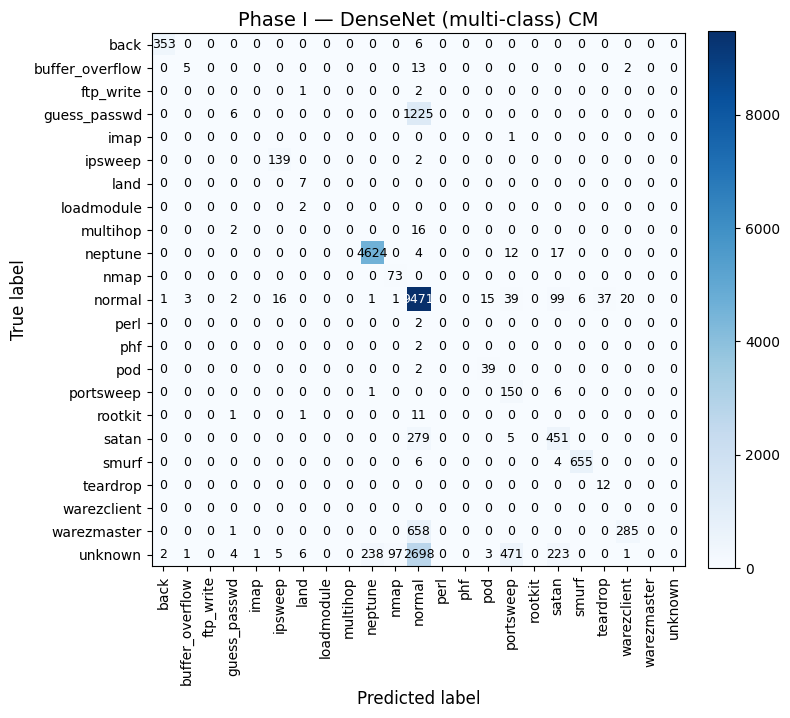

[SAVED] phase1_densenet_multiclass.pth



In [ ]:
_, acc1, cm1, names1 = evaluate_phase1(phase1_model, test_loader, device, class_names)

plot_confusion_matrix_multi(cm1, names1, title="Phase I — DenseNet (multi-class) CM", normalize=False, save_path="model/KDD/cm_phase1_multiclass.png")

torch.save(phase1_model.state_dict(), "model/KDD/phase1_densenet_multiclass.pth")
print("[SAVED] phase1_densenet_multiclass.pth\n")

In [16]:
print("EXTRACTING NON-NORMAL SAMPLES FROM PHASE I")
phase2_train_ds, test_anomaly_mask, _, _ = get_phase1_anomalies(
    phase1_model, X_train, y_train, X_test, y_test, device, normal_class_id
)

phase2_train_loader = DataLoader(phase2_train_ds, batch_size=BATCH_SIZE, shuffle=True)

EXTRACTING NON-NORMAL SAMPLES FROM PHASE I

[INFO] Phase I predicted 58793 NON-NORMAL samples out of 125973
[INFO] Creating Phase II dataset with 58793 anomaly samples
[INFO] Anomaly class distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 10, 11, 14, 15, 16, 17, 18, 20,
       21, 22]), array([  945,    19,     3,    53,     8,  3578,    18,     1, 41213,
        1483,   454,   201,  2925,     1,  3555,  2628,   892,   815,
           1]))


In [17]:
print("PHASE II: DeepNet Training (Multi-Class)")
phase2_model = DeepNet(input_dim, num_classes).to(device)
optimizer2 = optim.AdamW(phase2_model.parameters(), lr=LR, weight_decay=1e-4)

train_model(phase2_model, phase2_train_loader, criterion, optimizer2, device, EPOCHS)

PHASE II: DeepNet Training (Multi-Class)
Epoch [1/20] Loss: 0.2847
Epoch [2/20] Loss: 0.0695
Epoch [3/20] Loss: 0.0574
Epoch [4/20] Loss: 0.0530
Epoch [5/20] Loss: 0.0505
Epoch [6/20] Loss: 0.0481
Epoch [7/20] Loss: 0.0478
Epoch [8/20] Loss: 0.0467
Epoch [9/20] Loss: 0.0448
Epoch [10/20] Loss: 0.0435
Epoch [11/20] Loss: 0.0429
Epoch [12/20] Loss: 0.0416
Epoch [13/20] Loss: 0.0410
Epoch [14/20] Loss: 0.0400
Epoch [15/20] Loss: 0.0388
Epoch [16/20] Loss: 0.0387
Epoch [17/20] Loss: 0.0379
Epoch [18/20] Loss: 0.0362
Epoch [19/20] Loss: 0.0357
Epoch [20/20] Loss: 0.0351


In [18]:
torch.save(phase2_model.state_dict(), "model/KDD/phase2_deepnet_multiclass.pth")
print("\n[SAVED] phase2_deepnet_multiclass.pth\n")


[SAVED] phase2_deepnet_multiclass.pth



EVALUATING CASCADE SYSTEM
[INFO] Phase I sent 8147 non-normal samples to Phase II
[INFO] Phase II reclassified 21 back to 'normal'

CASCADE EVALUATION (Phase I → Phase II)
Confusion Matrix:
[[ 353    0    0    0    0    0    0    0    0    0    0    6    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    5    0    0    0    0    0    0    0    0    0   13    0    0
     0    0    0    0    0    0    2    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    3    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    6    0    0    0    0    0    0    0 1225    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    1    0    0    0    0    0    0    0]
 [   0    0    0    0    0  139    0    0    0    0    0    2    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    7    0    0    0    0    0    0    0
     0    0    0  

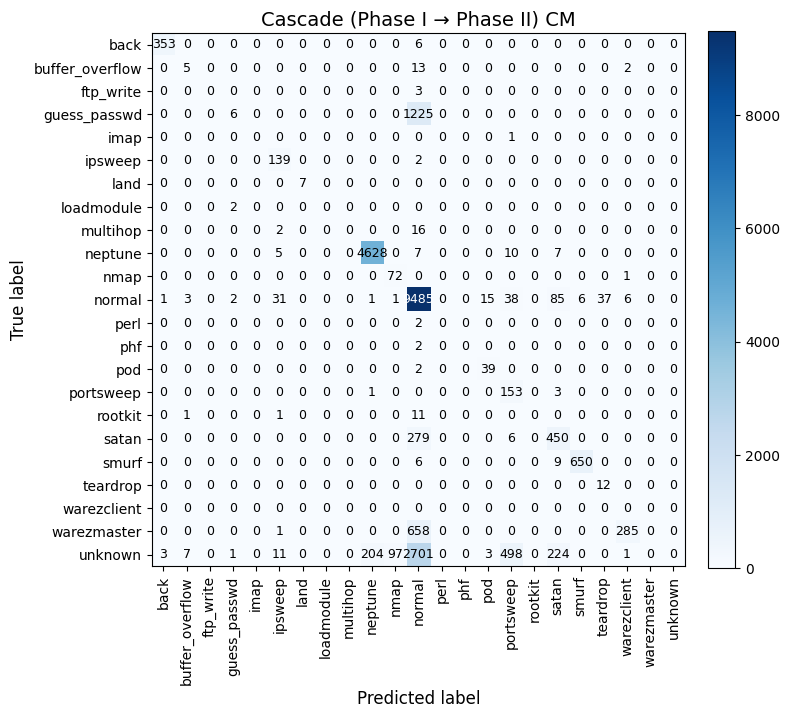

In [ ]:
print("EVALUATING CASCADE SYSTEM")
acc_cascade, cm_c, names_c = evaluate_cascade(phase1_model, phase2_model, X_test, y_test, device, class_names, normal_class_id)
plot_confusion_matrix_multi(cm_c, names_c, title="Cascade (Phase I → Phase II) CM", normalize=False, save_path="model/KDD/cm_cascade_multiclass.png")

In [20]:
print(f"Phase I (Multi-Class)  → Accuracy: {acc1:.4f} ({acc1*100:.2f}%)")
print(f"Cascade (I → II)       → Accuracy: {acc_cascade:.4f} ({acc_cascade*100:.2f}%)")

Phase I (Multi-Class)  → Accuracy: 0.7091 (70.91%)
Cascade (I → II)       → Accuracy: 0.7097 (70.97%)
